<a href="https://colab.research.google.com/github/Gradsmith/Deep-Learning-HW4/blob/main/DL2022_HW4_P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Note:** This notebook is based on a kaggle notebook ([link](https://www.kaggle.com/code/ysthehurricane/image-caption-generator-tutorial/notebook)) that tries to achieve image captioning with a CNN+LSTM model. Due to the lack of time, I used this notebook as a basis of my answer for the question 2 of the programming excercises.

In [1]:
# Download COCO dataset annotations.
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip ./annotations_trainval2017.zip

--2023-02-05 20:31:53--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.207.73, 52.216.52.153, 52.217.194.49, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.207.73|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  43.0MB/s    in 6.0s    

2023-02-05 20:31:59 (40.2 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

Archive:  ./annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


In [2]:
import itertools
import json
import os
import random
import string
import urllib.request
from itertools import chain
from pickle import dump, load

import cv2
import matplotlib.pyplot as plt
import nltk
import numpy as np
import skimage.io as io
import tensorflow as tf
from keras.utils import plot_model
from nltk.corpus import stopwords
from PIL import Image
from pycocotools.coco import COCO
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.layers import (LSTM, Add, Attention, Bidirectional,
                                     Dense, Dropout, Embedding, Input)
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tqdm.notebook import tqdm

# Download NLTK stopwords.
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Prepare COCO Dataset 

In [3]:
# Initialize COCO class
coco = COCO("./annotations/instances_train2017.json")

# Find Categories
cats = coco.loadCats(coco.getCatIds())

# Find Subcategories
subcategories = [cat['name'] for cat in cats]

# Find Subcategories with thier corresponding IDs
catIds = coco.getCatIds(catNms=subcategories)

# Find image IDs of each subcategory
subcategories_imageIds = dict()

for i in range(len(catIds)):
    imgIds = coco.getImgIds(catIds=catIds[i])
    img = []
    for j in imgIds: 
        img.append(j)
    subcategories_imageIds[subcategories[i]] = img
    

# Gather all image IDs in a list
imgIdss = coco.getImgIds(imgIds=list(chain.from_iterable(subcategories_imageIds.values())))

loading annotations into memory...
Done (t=17.10s)
creating index...
index created!


In [4]:
# Load image captions
annFile = "./annotations/captions_train2017.json"
coco_caps=COCO(annFile)

loading annotations into memory...
Done (t=0.90s)
creating index...
index created!


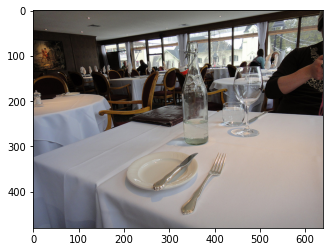


Image Captions:
A glass bottle on a white table cloth.
a table with a white table cloth and a bottle on it 
A bottle of drink next to a wine glass and a plate with silverware.
A table set with a table cloth, plate knife, fork, wine glass and bottle.
a person at a table a bottle glass and silverware


In [5]:
# Random visualization of an image and its captions.
img = coco.loadImgs(imgIdss[125])[0]
I = io.imread(img['coco_url'])
plt.imshow(I)
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
plt.show()
print('\nImage Captions:')
coco_caps.showAnns(anns)

# Preprocess and Tokenize the Captions

Now, we preprocess all the captions, group the related ones, and store them in a dictionary.

In [6]:
dataset = dict()
imgcaptions = []

for imgid in imgIdss:
    img = coco.loadImgs(imgid)[0]
    annIds = coco_caps.getAnnIds(imgIds=img['id']);
    anns = coco_caps.loadAnns(annIds)
    imgcaptions = []
    for cap in anns:
        
        # Remove punctuation.
        cap = cap['caption'].translate(str.maketrans('', '', string.punctuation))
        
        # Replace - with blank.
        cap = cap.replace("-"," ")
        
        # Split string into word list and Convert each word into lower case.
        cap = cap.split()
        cap = [word.lower() for word in cap]
        
        # Add <start> and <end> tags to each sentence. 
        cap = '<start> ' + " ".join(cap) + ' <end>'
        imgcaptions.append(cap)
        
    dataset[img['coco_url']] = imgcaptions 
    
    
print("Length of Captions Dataset: ",len(dataset))

Length of Captions Dataset:  117266


In [7]:
# Put all captions in a list.
flatten_list = list(chain.from_iterable(dataset.values()))

# Tokenize the captions.
tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(flatten_list)
total_words = len(tokenizer.word_index) + 1

print("Vocabulary Size: ", total_words)

Vocabulary Size:  28649


We also need to know the maximum length of captions to pad the inputs of our LSTM.

In [8]:
max_length = max([len(x[0].split()) for x in list(dataset.values())])
print("Maximum Length of Captions: ", max_length)

Maximum Length of Captions:  51


# Define a Data Generator


Due to the large nature of COCO dataset, we define a data generator to load the input data and labels batch by batch. This method ensures us that we can train our model without facing any memory overflow issues.

In [9]:
#create input-output sequence pairs from the image description.
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():

            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield ([input_image, input_sequence], output_word)
            

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    
    # walk through each description for the image
    for desc in desc_list:
        
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=total_words)[0]
            
            # store
            X1.append(feature) # image features
            X2.append(in_seq)  # Caption input
            y.append(out_seq)  # Caption output
            
    return np.array(X1), np.array(X2), np.array(y)

# Define the CNN+LSTM Model


## Extract Image features

In this section, we use the pretrained Xception model on the Imagenet dataset and extract image features.

**Note: From this point forward, we use a subset of COCO dataset to reduce the feature extraction and model training times.**

In [23]:
dataset_sampled = list(dataset.items())
random.shuffle(dataset_sampled)
dataset_sampled = dict(dataset_sampled[:5000])

In [24]:
xception_model = Xception(include_top=False, pooling='avg')

image_features = {}

for img in tqdm(dataset_sampled.keys()):
    image = io.imread(img)
    if image.ndim != 3:
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
    
    # Resize each image size 299 x 299
    image = cv2.resize(image,(299,299))
    image = np.expand_dims(image, axis=0)
    
    # Normalize image pixels
    image = image/127.5
    image = image - 1.0

    # Extract features from image
    feature = xception_model.predict(image, verbose=0)
    image_features[img] = feature

  0%|          | 0/5000 [00:00<?, ?it/s]

## Model Architechture

In [25]:
# define the captioning model
def define_model(total_words, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(total_words, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = Add()([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(total_words, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

## Train the Model

In [27]:
# Instantiate and train the model.
model = define_model(total_words, max_length)
generator = data_generator(dataset_sampled, image_features, tokenizer, max_length)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 51)]         0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 51, 256)      7334144     ['input_8[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 2048)         0           ['input_7[0][0]']                
                                                                                            

In [29]:
model.fit(generator, epochs=1, steps_per_epoch=len(dataset_sampled))

5000/5000 [==============================] - 796s 159ms/step - loss: 2.4826


In [30]:
model.save("Captioning Model.h5")

# Model Evaluation

In [33]:
def extract_features(filename, model):
        try:
            image = Image.open(filename)

        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image, verbose=0)
        return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        
        if word is None:
            break
        in_text += ' ' + word
        
        if word == 'end':
            break
    return in_text

In [47]:
# Get urls of a few random images and download them.
idx = np.random.default_rng(seed=42).integers(len(dataset_sampled), size=6)
img_urls = [list(dataset_sampled.keys())[i] for i in idx]

name = 1
img_paths = []
for url in img_urls:
    urllib.request.urlretrieve(url, str(name)+'.jpg')
    img_paths.append(str(name)+'.jpg')
    name += 1

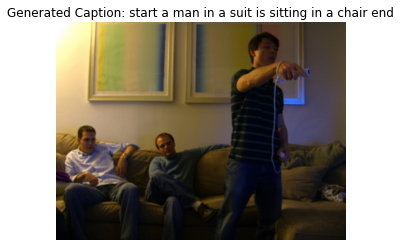

--------------------------------------------------


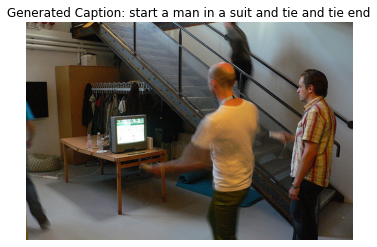

--------------------------------------------------


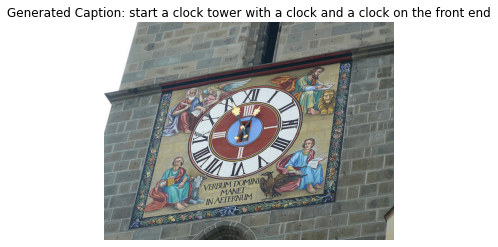

--------------------------------------------------


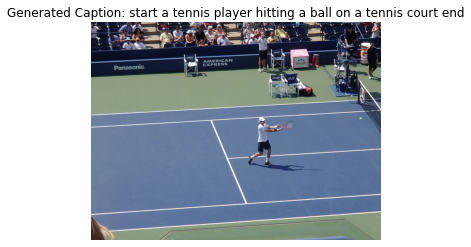

--------------------------------------------------


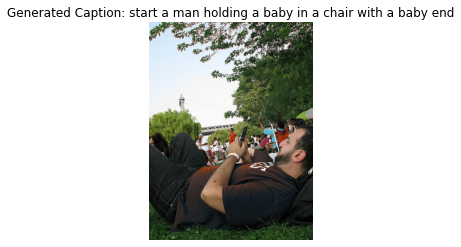

--------------------------------------------------


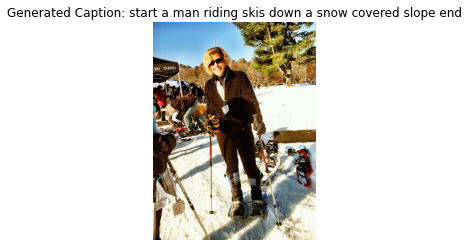

--------------------------------------------------


In [48]:
for i in range(len(img_paths)):
    photo = extract_features(img_paths[i], xception_model)
    img = Image.open(img_paths[i])
    description = generate_desc(model, tokenizer, photo, max_length)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Generated Caption: '+description)
    plt.show()
    print('-'*50)